In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, scipy.optimize, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict
import sys

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [7]:
def prepare_country_prediction(country_name, first_date, init_add=0.0):
    mortality_analysis = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=init_add)
    
    ldf = mortality_analysis.prepend_df[mortality_analysis.prepend_df.index >= first_date].copy()
    country_df = ldf.confirmed.reset_index(drop=True)
    # .reset_index(drop=True).reset_index(name='x')
    country_df.index.name = 'x'
    country_df = country_df.reset_index().astype(np.float)
    country_df.index = ldf.index
    country_df['x'] = country_df['x'] + 1.0
    
    last_value = float(country_df.confirmed.iloc[-1])
    
    with pm.Model() as sigmoid_model:
        # Define priors
        sm_scale        = pm.Gamma('scale', mu=2*last_value, sigma=2*last_value)
        sm_intercept    = pm.Normal('a', 0, sd=100.0)
        sm_coeff        = pm.Exponential('b', lam=4.0)
        sm_sigma        = pm.HalfCauchy('sigma', beta=100.0)
        sm_sigmoid      = sm_scale * pm.math.sigmoid(sm_intercept + sm_coeff * country_df['x'])
        sm_nu           = pm.Uniform('nu', lower=1, upper=100)

        # Define likelihood
        sm_likelihood   = pm.StudentT('y', mu=sm_sigmoid, sd=sm_sigma, nu=sm_nu, observed=country_df['confirmed'])

    
    return country_df, sigmoid_model

In [8]:
df = covid19.get_cases_by_region(region='Austria')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-28,8662,225,68,515,0,10
2020-03-29,9066,479,86,404,254,18
2020-03-30,9618,636,108,552,157,22
2020-03-31,10223,1095,128,605,459,20
2020-04-01,10711,1436,146,488,341,18


In [9]:
df[df.death>0].iloc[[0]]

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-12,445,4,1,199,0,1


In [10]:
austria_df, austria_sigmoid_model = prepare_country_prediction('Austria', pd.to_datetime('2020-03-12'), init_add=0)
display_side_by_side(austria_df.head(), austria_df.tail())

,x,confirmed
2020-03-12,1.0,445.0
2020-03-13,2.0,635.0
2020-03-14,3.0,819.0
2020-03-15,4.0,1028.0
2020-03-16,5.0,1315.0
,x,confirmed
2020-03-28,17.0,8662.0
2020-03-29,18.0,9066.0
2020-03-30,19.0,9618.0
2020-03-31,20.0,10223.0


In [11]:
with austria_sigmoid_model:
    sma_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, b, a, scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:28<00:00, 968.75draws/s] 
The acceptance probability does not match the target. It is 0.657041203377343, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
sma_df = pm.summary(sma_trace)
sma_df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-3.362,0.040,-3.436,-3.285,0.000,0.000,7196.0,7186.0,7253.0,9302.0,1.0
scale,12246.271,178.199,11914.873,12587.660,2.117,1.497,7089.0,7085.0,7105.0,9879.0,1.0
b,0.249,0.005,0.239,0.258,0.000,0.000,5977.0,5974.0,5988.0,7463.0,1.0
sigma,94.511,17.044,64.968,126.053,0.189,0.133,8154.0,8154.0,7554.0,4972.0,1.0
nu,52.190,27.858,9.557,99.988,0.283,0.212,9663.0,8599.0,9045.0,7779.0,1.0


In [13]:
a     = sma_df.loc['a', 'mean']
b     = sma_df.loc['b', 'mean']
scale = sma_df.loc['scale', 'mean']
a,b,scale

(-3.362, 0.249, 12246.271)

In [14]:
x = austria_df.x
austria_df['sigmoid_fit'] = scale/(1+np.exp(-(b * x + a)))

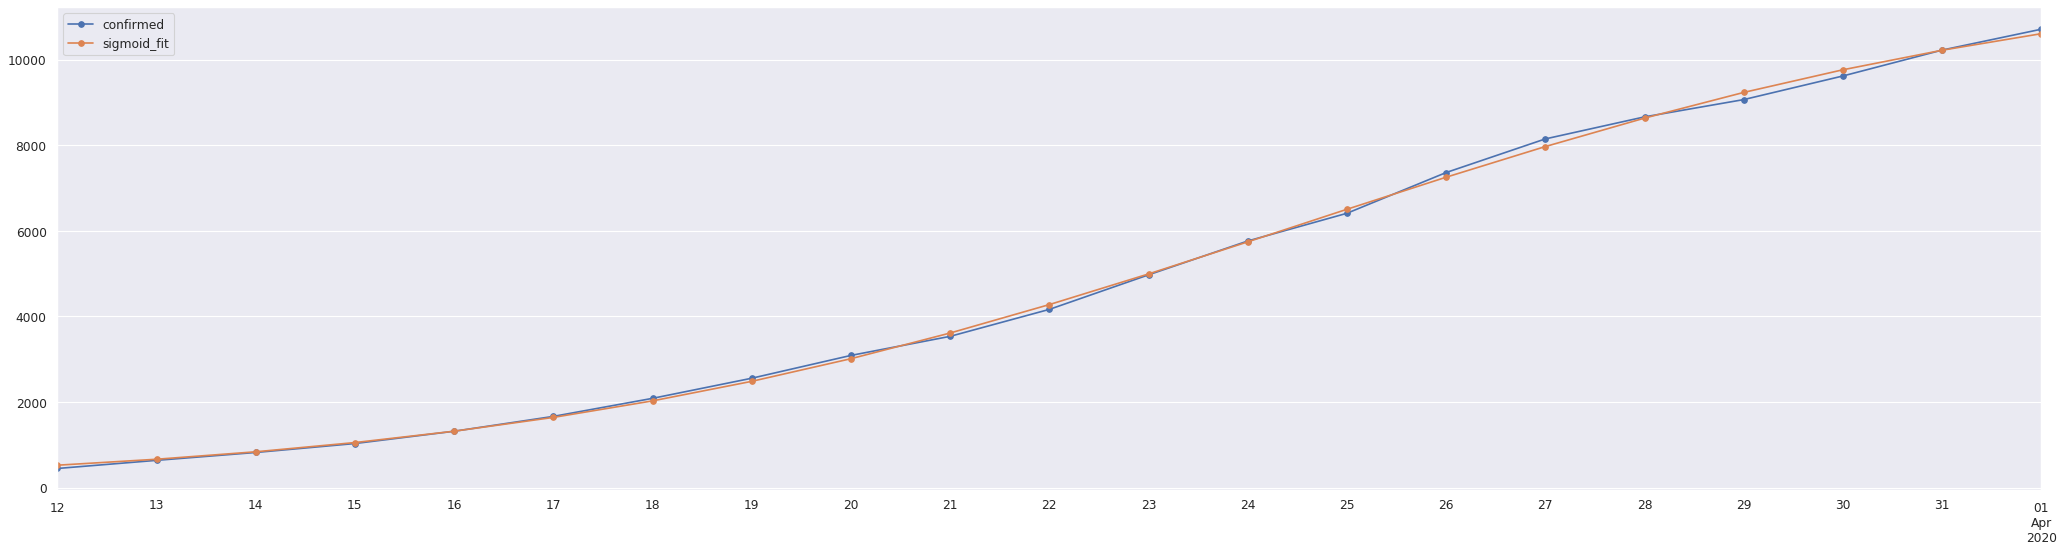

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
austria_df[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [16]:
austria_df.iloc[int(-sma_df.loc['a', 'mean']/sma_df.loc['b', 'mean']) + 1]

x                15.000000
confirmed      7361.000000
sigmoid_fit    7252.041886
Name: 2020-03-26 00:00:00, dtype: float64

In [17]:
# with pm.Model() as exponential_model_austria:
#     # Define priors
#     ema_scale        = pm.Gamma('scale', mu=2*last_value_austria, sigma=2*last_value_austria, testval=last_value_austria)
#     # sma_scale        = pm.Uniform('scale', lower=0.0, upper=5.0 * last_value_austria)
#     ema_coeff        = pm.Exponential('b', lam=4.0)
#     ema_sigma        = pm.HalfCauchy('sigma', beta=100.0)
#     ema_exp          = ema_scale * pm.math.exp(ema_coeff * austria_df['x'])
#     ema_nu           = pm.Uniform('nu', lower=1, upper=100)

#     # Define likelihood
#     ema_likelihood   = pm.StudentT('y', mu=ema_exp, sd=ema_sigma, nu=ema_nu, observed=austria_df['confirmed'])
    
#     ema_trace = pm.sample(5000, tune=2000)

In [18]:
# ema_df = pm.summary(ema_trace)
# ema_df

In [19]:
# b     = ema_df.loc['b', 'mean']
# scale = ema_df.loc['scale', 'mean']
# a, b, scale

In [20]:
# austria_df['exp_fit'] = scale * np.exp(b*austria_df.x)

In [21]:
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# austria_df[['confirmed', 'sigmoid_fit', 'exp_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [22]:
# sigmoid_model_austria.name     = 'sigmoid_model_austria'
# exponential_model_austria.name = 'exponential_model_austria'
# model_trace_dict = {sigmoid_model_austria: sma_trace, exponential_model_austria: ema_trace}
# dfwaic = pm.compare(model_trace_dict, ic='WAIC')
# dfwaic

In [23]:
# hex(id(sigmoid_model_austria))

In [24]:
# hex(id(exponential_model_austria))

In [25]:
# fig = plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# pm.compareplot(dfwaic, ax=ax)

In [26]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-28,54268,8481,398,5229,1549,75
2020-03-29,58655,9291,456,4387,810,58
2020-03-30,62526,13500,565,3871,4209,109
2020-03-31,67074,15826,702,4548,2326,137
2020-04-01,72956,19175,867,5882,3349,165


In [27]:
df[df.death>0].iloc[[0]]

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-09,1176,18,2,136,0,2


In [28]:
germany_df, germany_sigmoid_model = prepare_country_prediction('Germany', pd.to_datetime('2020-03-09'), init_add=0)
display_side_by_side(germany_df.head(), germany_df.tail())

,x,confirmed
2020-03-09,1.0,1176.0
2020-03-10,2.0,1457.0
2020-03-11,3.0,1908.0
2020-03-12,4.0,2750.0
2020-03-13,5.0,3675.0
,x,confirmed
2020-03-28,20.0,54268.0
2020-03-29,21.0,58655.0
2020-03-30,22.0,62526.0
2020-03-31,23.0,67074.0


In [29]:
with germany_sigmoid_model:
    smg_trace = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, b, a, scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:52<00:00, 528.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [30]:
smg_df = pm.summary(smg_trace)
smg_df

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-4.148,0.068,-4.277,-4.017,0.001,0.001,4940.0,4906.0,5120.0,4365.0,1.0
scale,92599.097,3169.677,86593.413,98592.348,47.241,33.407,4502.0,4502.0,4428.0,4705.0,1.0
b,0.224,0.007,0.211,0.237,0.000,0.000,3734.0,3662.0,3953.0,4071.0,1.0
sigma,897.082,166.666,600.059,1228.323,2.268,1.604,5399.0,5399.0,5777.0,3335.0,1.0
nu,48.413,29.557,1.006,94.176,0.325,0.230,8277.0,8277.0,6335.0,3626.0,1.0


In [31]:
a     = smg_df.loc['a', 'mean']
b     = smg_df.loc['b', 'mean']
scale = smg_df.loc['scale', 'mean']
a,b,scale

(-4.148, 0.224, 92599.097)

In [32]:
x = germany_df.x
germany_df['sigmoid_fit'] = scale/(1+np.exp(-(b * x + a)))

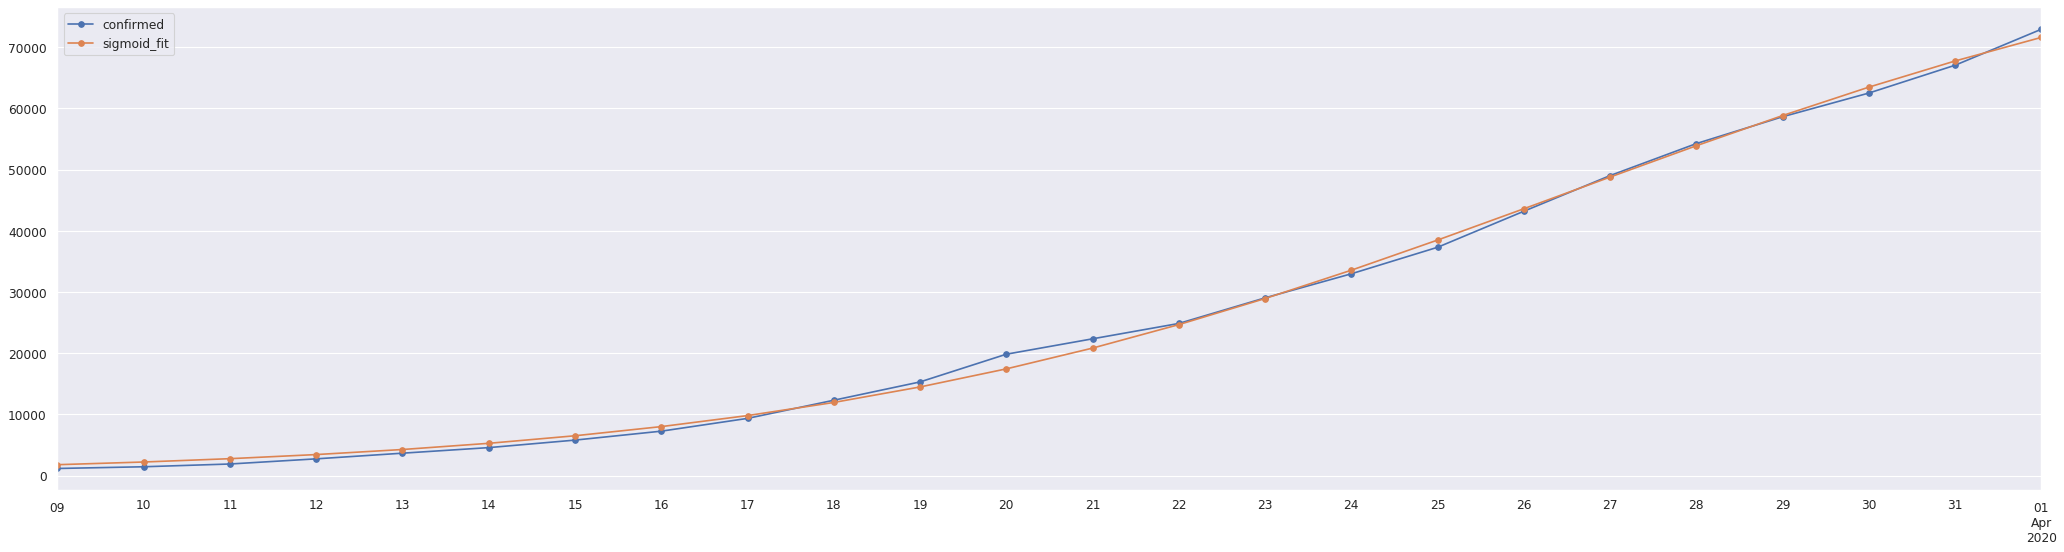

In [33]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
germany_df[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)

In [34]:
germany_df.iloc[int(-smg_df.loc['a', 'mean']/smg_df.loc['b', 'mean']) + 1]

x                 20.000000
confirmed      54268.000000
sigmoid_fit    53915.447158
Name: 2020-03-28 00:00:00, dtype: float64

In [35]:
df = covid19.get_cases_by_region('Denmark')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-28,2366,57,65,166,0,13
2020-03-29,2564,73,72,198,16,7
2020-03-30,2755,73,77,191,0,5
2020-03-31,3039,77,90,284,4,13
2020-04-01,3290,971,104,251,894,14


In [36]:
df[df.death>0].iloc[[0]]

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,836,1,1,32,0,1


In [37]:
denmark_df, denmark_sigmoid_model = prepare_country_prediction('Denmark', pd.to_datetime('2020-03-09')) # pd.to_datetime('2020-03-14'), init_add=200.0
display_side_by_side(denmark_df.head(), denmark_df.tail())

,x,confirmed
2020-03-09,1.0,92.0
2020-03-10,2.0,264.0
2020-03-11,3.0,444.0
2020-03-12,4.0,617.0
2020-03-13,5.0,804.0
,x,confirmed
2020-03-28,20.0,2366.0
2020-03-29,21.0,2564.0
2020-03-30,22.0,2755.0
2020-03-31,23.0,3039.0


In [38]:
# with denmark_sigmoid_model:
#     smd_trace = pm.sample(5000, tune=2000)

In [39]:
# smd_df = pm.summary(smd_trace)
# smd_df

In [40]:
# a     = smd_df.loc['a', 'mean']
# b     = smd_df.loc['b', 'mean']
# scale = smd_df.loc['scale', 'mean']
# a,b,scale

In [41]:
# x = denmark_df.x
# denmark_df['sigmoid_fit'] = scale/(1+np.exp(-(b * x + a)))

In [42]:
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# denmark_df[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5)